# Preliminary Data Exploration: Medium.com employee data

In this notebook we explore human resources data provided by Medium on Kaggle (https://www.kaggle.com/ludobenistant/hr-analytics). It is simulated employee data of 15000 employees, and the goal is to understand something about what might cause an employee to prematurely leave the company.

In [1]:
%matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from __future__ import print_function

In [4]:
sns.set_context("talk")

## Read in data

In [5]:
#data is comma-delimited csv, with headers in the first line
df = pd.read_csv('HR_comma_sep.csv')

In [6]:
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

We have lots of interesting information that might impact an employee's attitudes. We have direct measures of her general happiness level (satisfaction_level) and her employer's attitude about her (last_evaluation). A measure of workload can be gauged from number of projects and average monthly hours. A measure of rewards from the employer can be found in salary and number of promotions in the last 5 years. Her status in the company could be gleaned from her salary level, department, time spent at the company, and number of projects. 

The data is pretty clean. There is no missing data, and formats are all sensible. Ratings are already normalized to be between 0 and 1. We're ready to start looking for interesting features in the data!

In [7]:
#what are possible values for sales
set(df.sales)

{'IT',
 'RandD',
 'accounting',
 'hr',
 'management',
 'marketing',
 'product_mng',
 'sales',
 'support',
 'technical'}

In [8]:
#what are possible values for salary
set(df.salary)

{'high', 'low', 'medium'}

## Data Exploration

The package seaborn has some great plotting functions that make it easy to see interactions between features, as well as the distribution of values in a feature. As busy as this plot is, it provides almost all pairwise comparisons you might want to do all in one graph. It won't plot the textual categorical data, so for the purposes of plotting, we will convert the categories into integers.

In [9]:
salary = {'low':1, 'medium':2, 'high':3}
sales = {'IT':1, 'RandD':2, 'accounting':3, 'hr':4, 'management':5, 
         'marketing':6, 'product_mng':7, 'sales':8, 'support':9, 'technical':10}
dfplot = df.copy()
dfplot = dfplot.replace({'salary':salary,'sales':sales})
dfplot.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                      int64
salary                     int64
dtype: object

['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 'sales', 'salary']


<IPython.core.display.Javascript object>


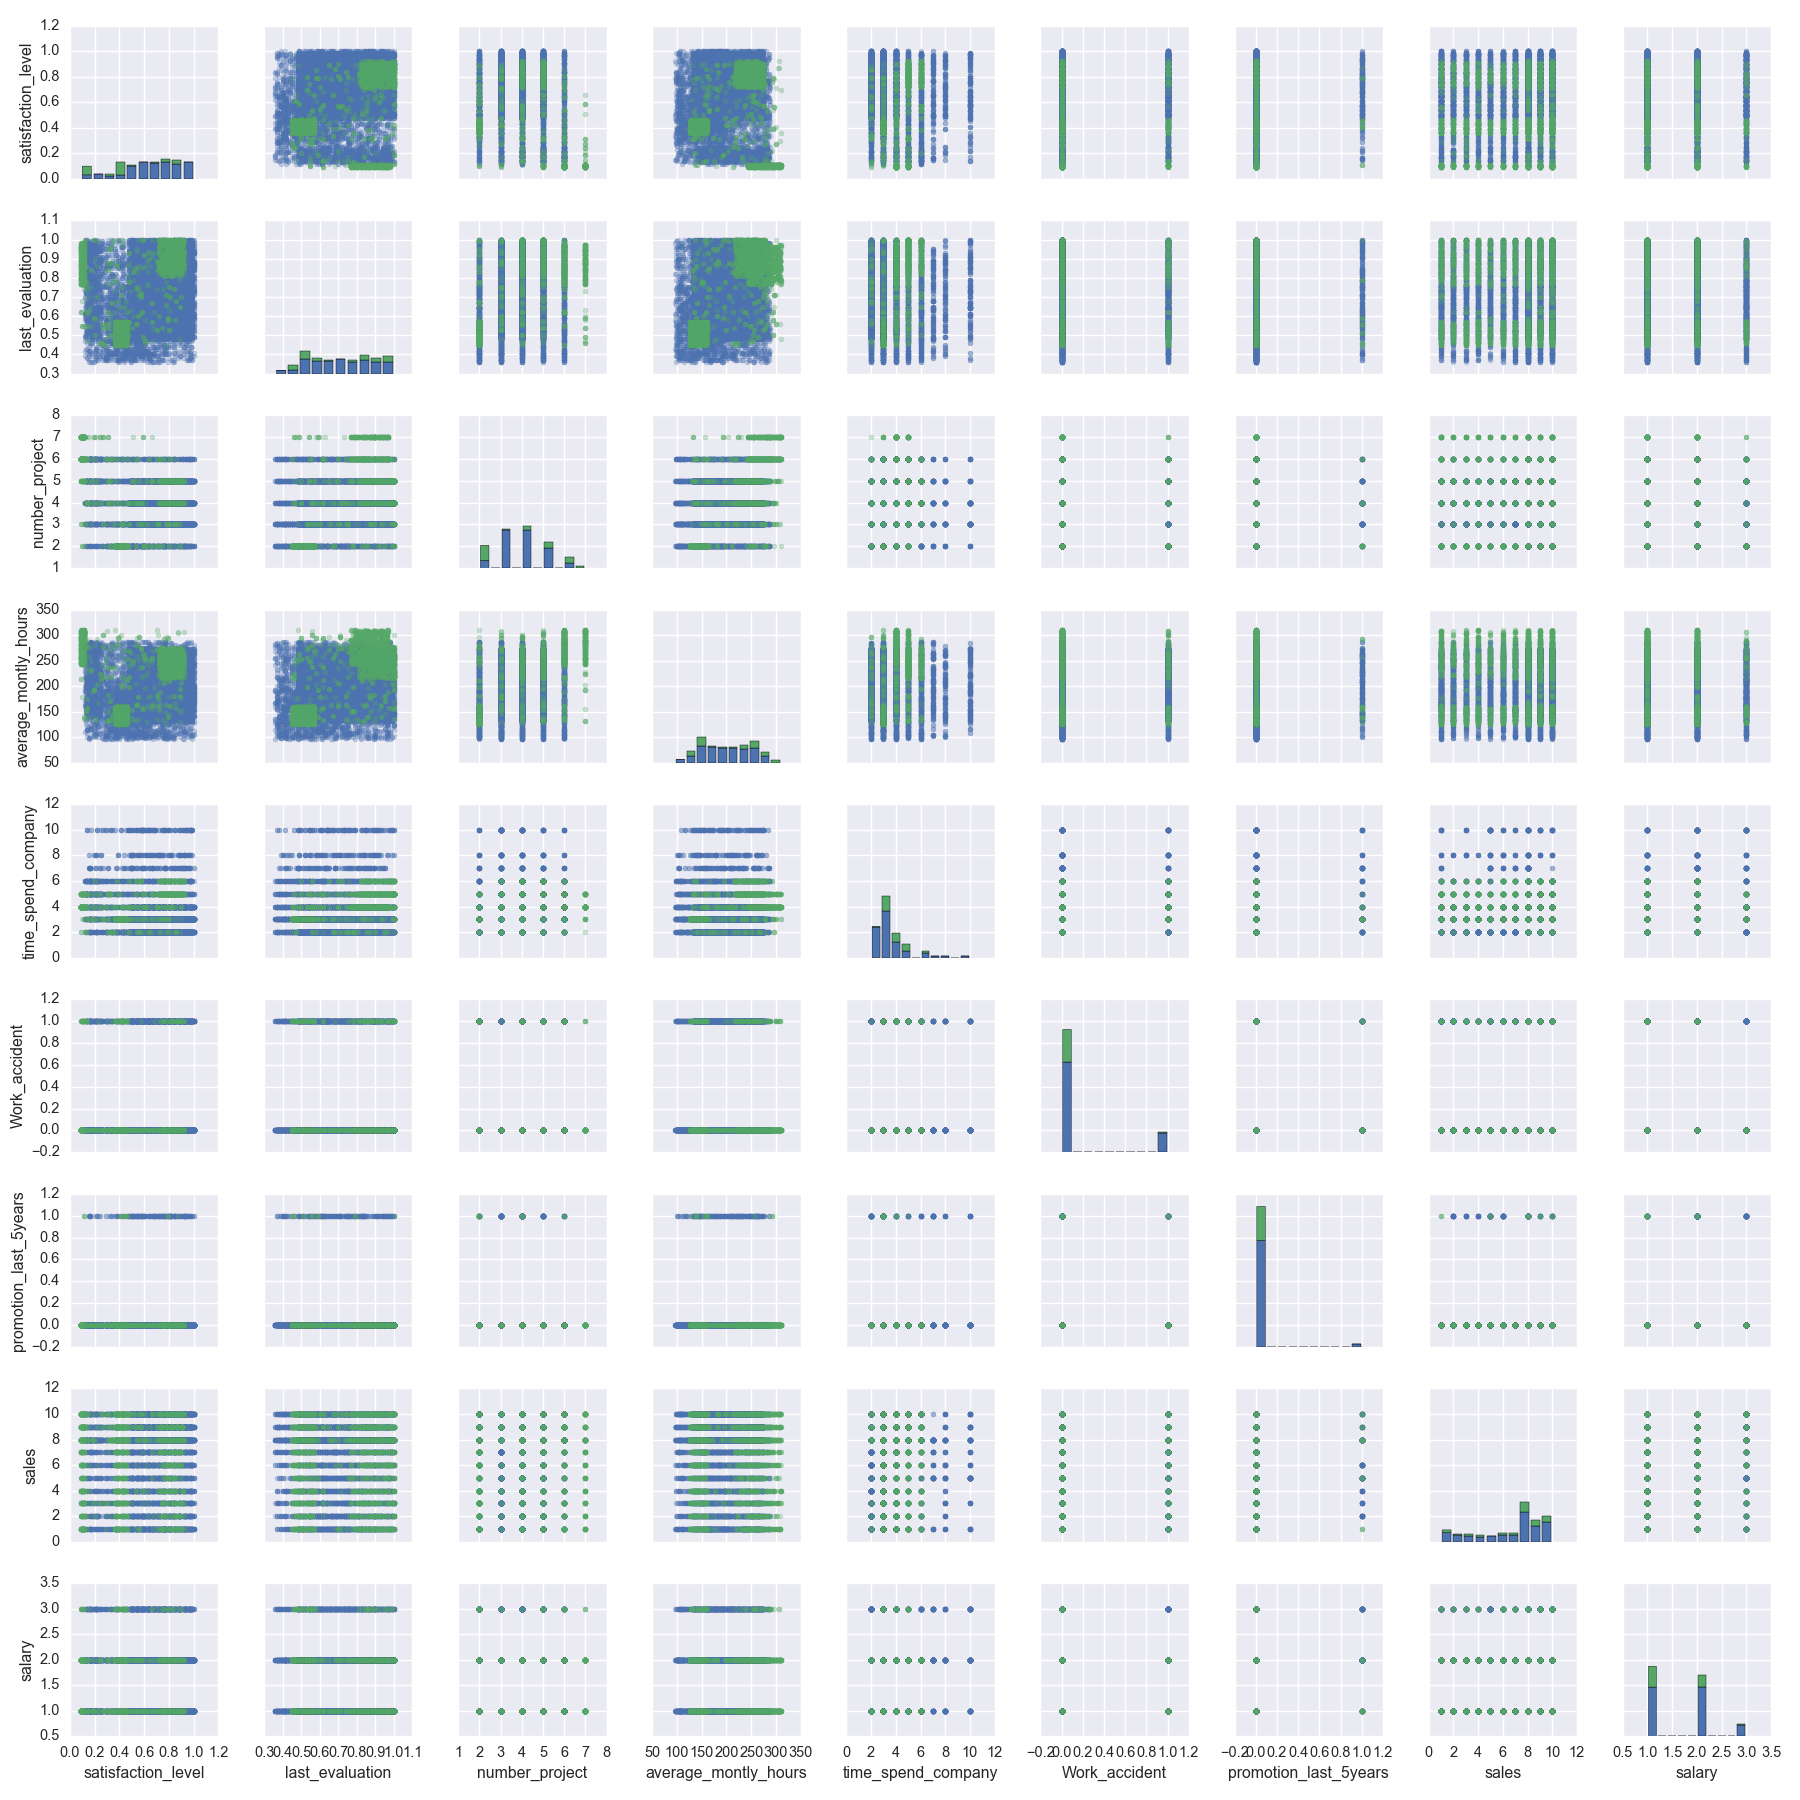

In [10]:
cols = dfplot.columns.tolist()
cols.remove('left')
print(cols)

g = sns.PairGrid(dfplot, hue='left', vars=cols)
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter,alpha=0.3)

The above plot is very busy, and it's clear that the partitioning is mainly happening in the first 5 features, so let's focus in on that.

<IPython.core.display.Javascript object>


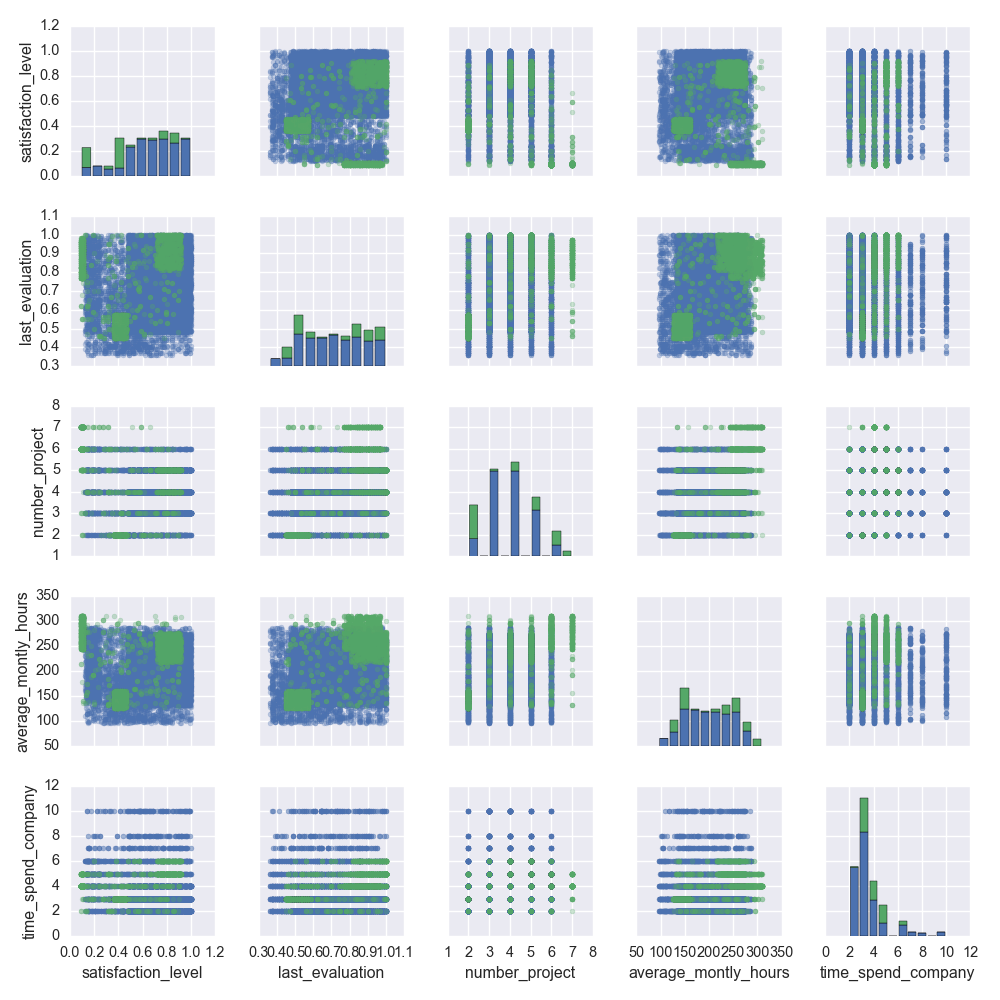

In [11]:
g = sns.PairGrid(df, hue='left', vars=df.columns[0:5])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter,alpha=0.3)

Some thoughts that come up looking at the plots above are: 
* is there a bimodal distribution for leaving - seems there are two peaks in most plots for leavers - those who have high or low satisfaction, high or low evaluations, and those who work part-time or overtime.
* there are clearly clusters of leavers when monthly hours and satisfaction level are compared
* there are no leavers if the employee has stayed over 6 years. Leavers will leave within 6 years.

There seems to be an interesting story behind the satisfaction vs work hours plots. Do they partition by department, or number of projects? as seen below, the answers are no, and yes, respectively. 

<IPython.core.display.Javascript object>


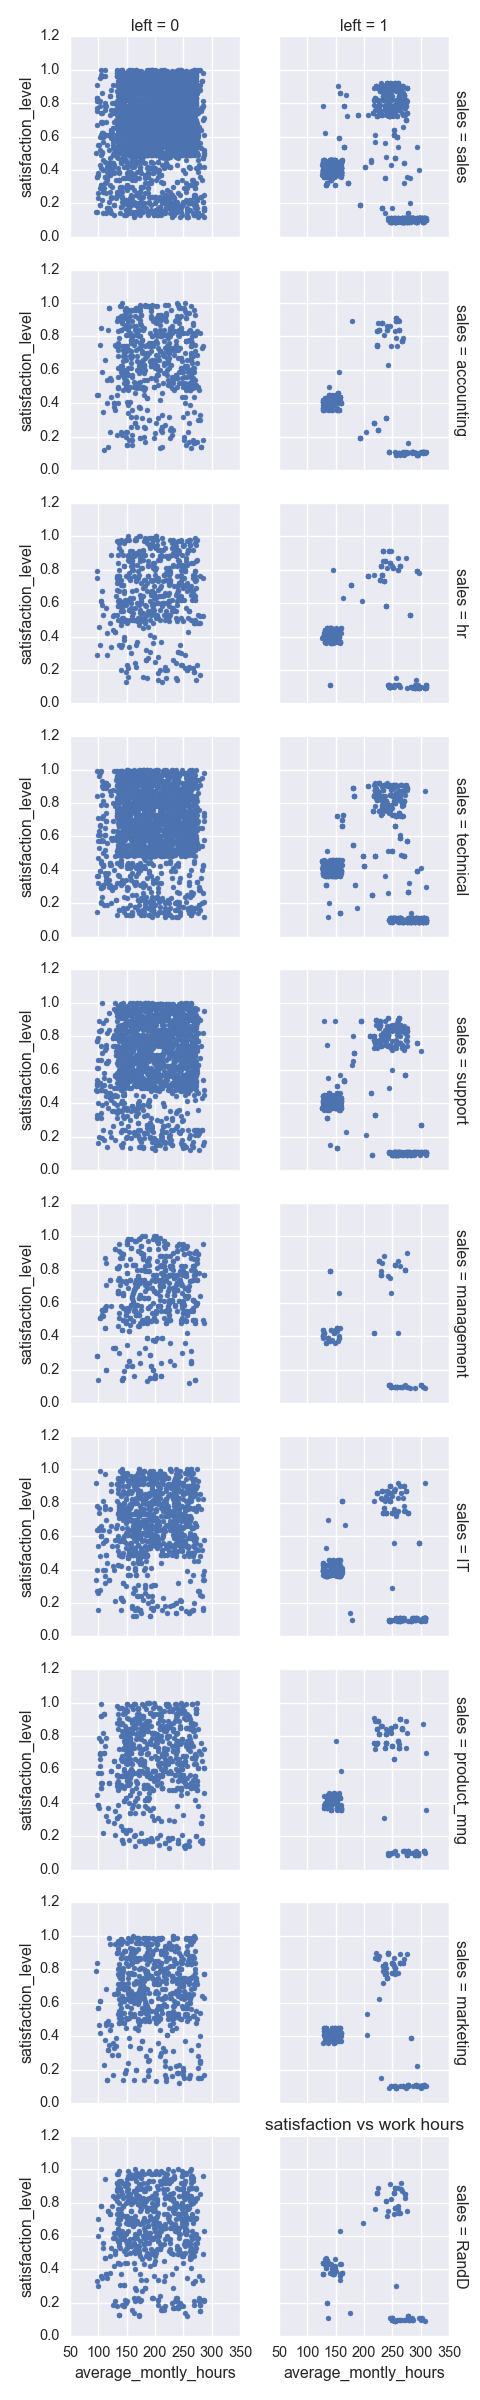

In [12]:
# satisfaction vs work hours for each department
g = sns.FacetGrid(df, row="sales", col="left", margin_titles=True)
g.map(plt.scatter, "average_montly_hours", "satisfaction_level")
plt.title('satisfaction vs work hours')

<IPython.core.display.Javascript object>


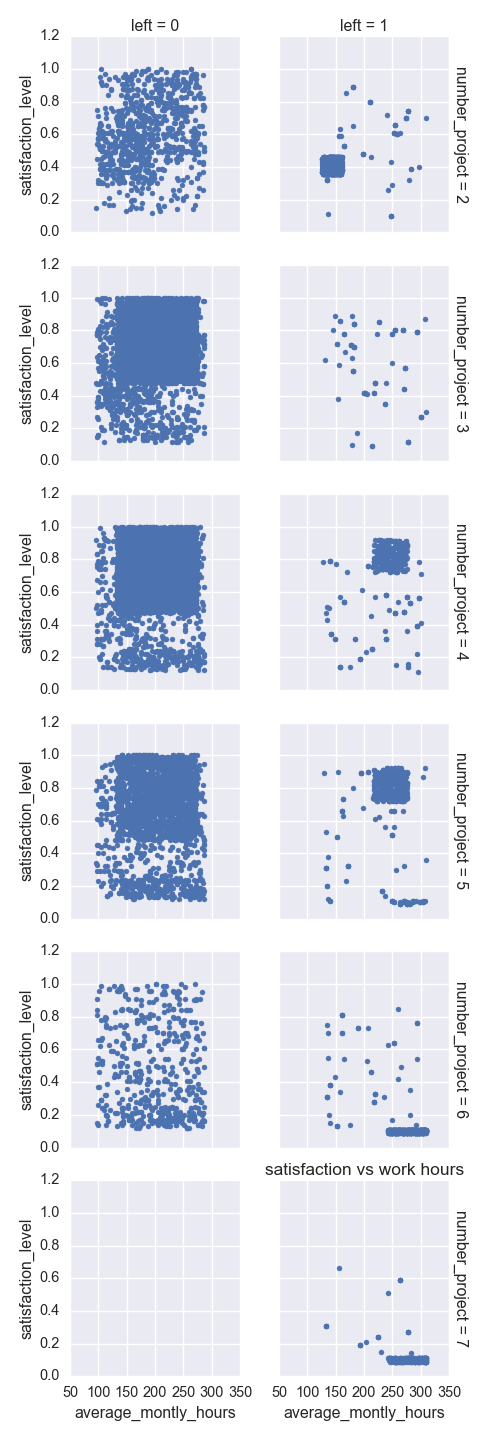

In [13]:
# satisfaction vs work hours per number of projects  
g = sns.FacetGrid(df, row="number_project", col="left", margin_titles=True)
g.map(plt.scatter, "average_montly_hours", "satisfaction_level")
plt.title('satisfaction vs work hours')

We can also make more satisfaction vs. work hours plots with color representing promotions, and salary - I've included them below for curiosity, but there are no clear patterns from promotions or salary in those plots.

So lucky us, the data already hints at some useful relationships and real take home messages as a result of the analysis.

The fact that we have some apparently useful demographics about our employees, and that we know if the employee left or not means we can apply machine learning, and we can use supervised learning algorithms. One of the benefits of some algorithms is you don't have to do any preliminary data exploration - the algorithm can decide for itself if a feature is relevant or not.

<IPython.core.display.Javascript object>


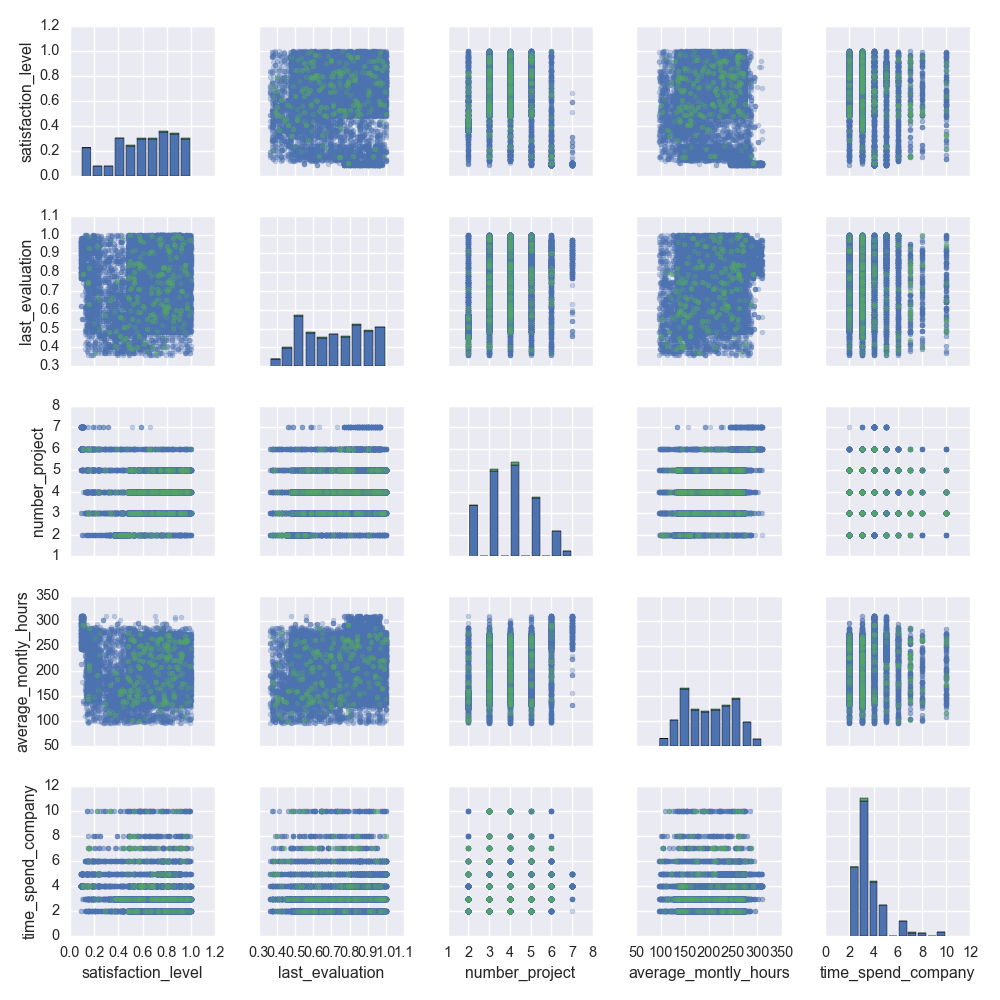

In [14]:
g = sns.PairGrid(df, hue='promotion_last_5years', vars=df.columns[0:5])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter,alpha=0.3)

<IPython.core.display.Javascript object>


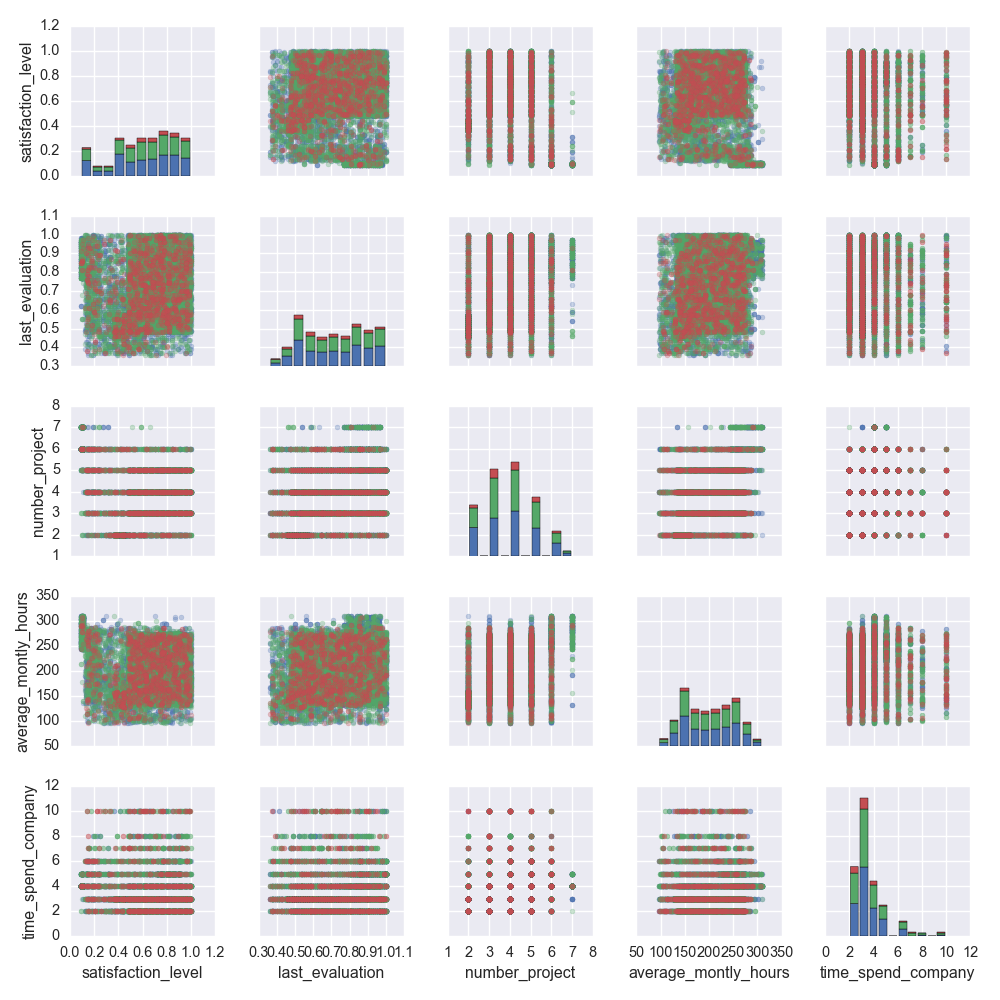

In [15]:
g = sns.PairGrid(df, hue='salary', vars=df.columns[0:5])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter,alpha=0.3)

## Feature selection and discovery

We are lucky here to explore the world of data science with a data set with features we can count on our fingers - in real life data situations, there may be hundreds of features to explore, in which case our method of creating scatter plots does not scale up. Do our instincts in manual data exploration educate how we might automate the processing of features?

What we did above was compare single features to our target result, which is a two state vector stating if the employee left the job or not. In other words, we manually looked at the correlation between individual features and the target. In some cases, features that are correlated result in poor modeling (naive Bayes) or the model does not return meaningful coefficients wrt feature importance; correlated features may be interchangeable. Recall that degrees of freedom of a categorical feature with n categories is n-1; once you know whether it is in one of the first n-1 categories or not, the value of the last category is deterministic. We will want to remove one of the categories from the inputs in the case of logistic regression. Here the correlation matrix gives us clues on the correlations between features.

<IPython.core.display.Javascript object>


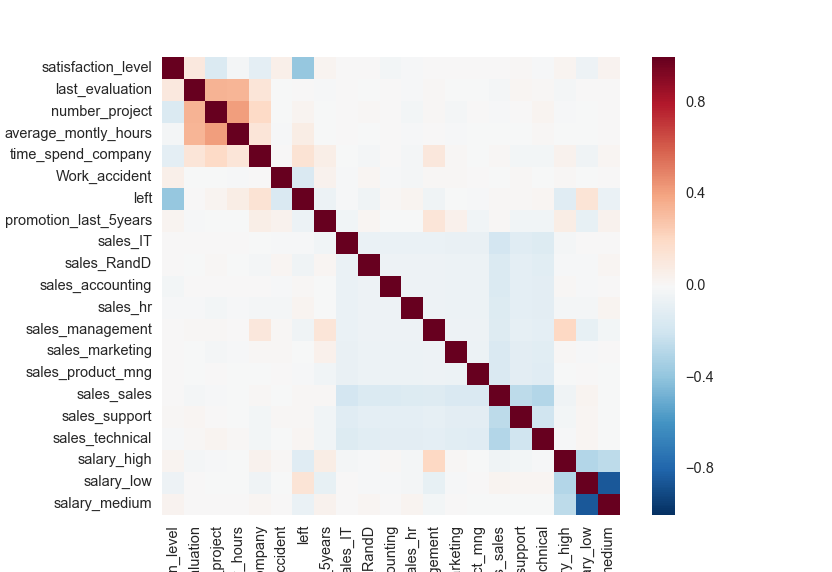

In [16]:
#first, let's convert categorical data into dummy variables, where each category is a feature, 
#and the value is true or false
dfd = pd.get_dummies(df)
corrmat = dfd.corr()

plt.figure()
sns.heatmap(corrmat, vmax=1., square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0);

We can see that the features that have some direct correlation with leaving is satisfaction level, along with at a lesser level time spent at the company and a low salary. Between the features, there is positive correlation among last_evaluation, number_project, and average_monthly_hours, and to a lesser degree time_spend_company and satisfaction_level. There are also correlations between being in management and a high salary, getting a promotion in the last 5 years, and the time spent in the company. There is also some correlation between categories within the same features, as highlighted above.  